> This is one of the 100 recipes of the [IPython Cookbook](http://ipython-books.github.io/), the definitive guide to high-performance scientific computing and data science in Python.


# 5.1. Accelerating pure Python code with Numba and Just-In-Time compilation

In this example, we first write a pure Python version of a function that generates a Mandelbrot fractal. Then, we use Numba to compile it dynamically to native code.

In [40]:
import numpy as np

We initialize the simulation and generate the grid
in the complex plane.

In [41]:
size = 500
iterations = 100

## Pure Python version

The following function generates the fractal.

In [43]:
def mandelbrot_python(m, size, iterations):
    for i in range(size):
        for j in range(size):
            c = -2 + 3./size*j + 1j*(1.5-3./size*i)
            z = 0
            for n in range(iterations):
                if np.abs(z) <= 10:
                    z = z*z + c
                    m[i, j] = n
                else:
                    break

In [44]:
m = np.zeros((size, size))
mandelbrot_python(m, size, iterations)

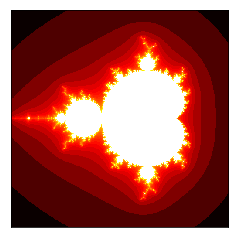

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(np.log(m), cmap=plt.cm.hot,);
plt.xticks([]); plt.yticks([]);

In [6]:
%%timeit m = np.zeros((size, size))
mandelbrot_python(m, size, iterations)

1 loops, best of 3: 5.01 s per loop


## Numba version

We first import Numba.

In [46]:
import numba
from numba import jit, complex128

Now, we just add the `@jit` decorator to the exact same function.

In [62]:
@jit(locals=dict(c=complex128, z=complex128))
def mandelbrot_numba(m, size, iterations,w=3.,x0=-2,y0=1.5):
    for i in range(size):
        for j in range(size):
            c = x0 + w/size*j + 1j*(y0-w/size*i)
            z = 0
            for n in range(iterations):
                if abs(z) <= 10:
                    z = z*z + c
                    m[i, j] = n
                else:
                    break

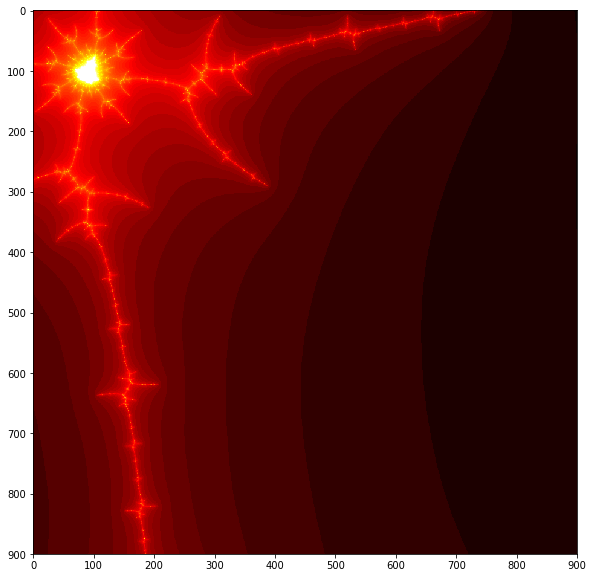

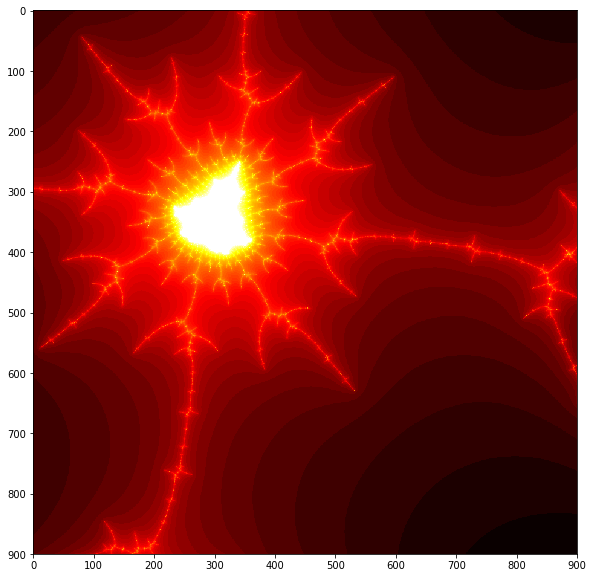

In [126]:

size=900
m = np.zeros((size, size))
#mandelbrot_numba(m, size, iterations,0.04,-1.79,0.02)
#mandelbrot_numba(m, size, iterations,0.007,-1.788,0.02)
#mandelbrot_numba(m, size, iterations,0.004,-1.788,0.02)
#mandelbrot_numba(m, size, iterations,0.001,-1.7874,0.02)
#mandelbrot_numba(m, size, iterations,0.0003,-1.78695,0.0195)
#fig = plt.figure(figsize=(10,10))
#mandelbrot_numba(m, size, iterations,0.0002,-1.78695,0.0195)
#plt.imshow(np.log(m), cmap=plt.cm.hot);

#fig = plt.figure(figsize=(10,10))
#mandelbrot_numba(m, size, iterations,0.0001,-1.78695,0.0195)
#plt.imshow(np.log(m), cmap=plt.cm.hot);

fig = plt.figure(figsize=(10,10))
mandelbrot_numba(m, size, iterations,0.0001,-1.78688,0.019454)
plt.imshow(np.log(m), cmap=plt.cm.hot);

fig = plt.figure(figsize=(10,10))
mandelbrot_numba(m, size, iterations,0.00003,-1.78688,0.019454)
plt.imshow(np.log(m), cmap=plt.cm.hot);
#plt.xticks([]); plt.yticks([]);

In [11]:
%%timeit m = np.zeros((size, size))
mandelbrot_numba(m, size, iterations)

100 loops, best of 3: 12.4 ms per loop


The Numba version is 250 times faster than the pure Python version here!

> You'll find all the explanations, figures, references, and much more in the book (to be released later this summer).

> [IPython Cookbook](http://ipython-books.github.io/), by [Cyrille Rossant](http://cyrille.rossant.net), Packt Publishing, 2014 (500 pages).

In [25]:
from numba import jit
from numpy import arange

# jit decorator tells Numba to compile this function.
# The argument types will be inferred by Numba when function is called.
@jit
def sum2d(arr):
    M, N = arr.shape
    result = 0.0
    for i in range(M):
        for j in range(N):
            result += arr[i,j]
    return result

a = arange(9).reshape(3,3)
print(sum2d(a))

36.0


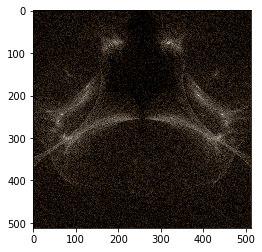

In [39]:
%matplotlib inline
from numba import jit, complex128
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt
from random import uniform
from PIL import Image, ImageDraw


width, height = 512, 512
counters = np.zeros((width, height))
img = Image.new('RGB', (width, height), (0, 0, 0))

iterations = 400
points = 100000
esc_radius = 30.0
real_dim, imag_dim = 4.0, 4.0
real_ratio = width / real_dim
imag_ratio = height / imag_dim
a, b, c, d, e = -0.1, -0.2, -0.4, -0.8, -1.0

@jit(parallel=True,nogil=True,locals=dict(w=complex128, z=complex128,P=complex128))
def loop():
    for i in range(points):
        z = 0
        path = []
        P = complex(uniform(-2.0, 2.0), uniform(-2.0, 2.0))

        for j in range(iterations):
            w = z.conjugate()
            z = a * w**5 + b * w**4 + c * w**3 + d * w**2 + e * w**1 + P
            path.extend([z.imag, z.real])

            if abs(z) > esc_radius:
                while path:
                    x = int(path.pop() * real_ratio + width / 2)
                    y = int(path.pop() * imag_ratio + height / 2)

                    if x > 0 and y > 0 and x < width and y < height:
                        counters[x][y] += 1
                        counters[x][-y] += 1
                break
loop()
                
max_count = np.amax(counters)

for x in range(width):
    for y in range(height):
        brightness = int(255 * sqrt(counters[x][y] / max_count))
        img.putpixel((y, x), (brightness - 10,  brightness - 20, brightness - 30))
img.save("fractal.png")


pil_im = Image.open('fractal.png', 'r')
plt.imshow(np.asarray(pil_im))